In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import pandas as pd
import numpy as np
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from tqdm import tqdm
tqdm.pandas()
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.font_manager as fm
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import matplotlib as mpl
mpl.use('pdf')
fpath = Path(mpl.get_data_path(), "fonts/ttf/cmu_serif_roman.ttf")
fprop = fm.FontProperties(fname=fpath)

width = 12.4 #inches
height = width/2.4

font = {'family':'serif', 'serif': ['cmr10']}
plt.rc('font',**font)
plt.rcParams['axes.unicode_minus'] = False
plt.rc('axes', titlesize=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

media = [
    'ARD_Monitor',
    'ARD_Hart aber fair',
    'ARD_Maischberger', 
    'ARD_Tagesthemen',
    'ARD_Anne Will',
    'ARD_youtube',
    'ZDF_maybrit illner', 
    'ZDF_Markus Lanz', 
    'ZDF_Frontal 21', 
    'ZDF_frontal', 
    'ZDF_youtube',
    'ZDFh_youtube',
    'rest'
]

search_terms = {
    'cdu':['cdu', 'union'],
    'csu':['csu', 'union'],
    'fdp':['fdp', 'freien demokraten'],
    'grüne':['grünen'],
    'linke':['linke', 'linkspartei'],
    'afd':['afd', 'afg'],
    'spd':['spd', 'sozialdemokraten'],
}

/Users/hs/miniforge3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
def extract_party_mentions(input_string, party_strings, n_words=10):
    input_string = input_string.lower()
    party_boolean = [False for i in input_string.split()]
    for p in party_strings:
        temp = [string.__contains__(p) for string in input_string.split()]
        party_boolean = [party_boolean|temp for (party_boolean,temp) in zip(party_boolean, temp)]
    party_index = np.where(party_boolean)[0]
    output_strings = ['' for _ in range(len(party_index))]
    for i in range(len(party_index)):
        lower_bound = party_index[i]-n_words
        upper_bound = party_index[i]+n_words
        if lower_bound < 0:
            lower_bound = 0
        if upper_bound > len(input_string.split()):
            upper_bound = len(input_string.split())
        output_strings[i] = " ".join(input_string.split()[lower_bound:upper_bound])
    return output_strings

def extract_mention_df(party):
    subset = 'contains_' + party
    res_series = df['transcript'].loc[df[subset]].parallel_apply(lambda transcript: extract_party_mentions(input_string=transcript, party_strings=search_terms[party], n_words=10))
    temp = {'medium': df['medium'].loc[df[subset]], 'transcript':res_series}
    res_df = pd.DataFrame(temp).explode(column='transcript')
    res_df.reset_index(inplace=True)
    res_df.dropna(inplace=True)
    res_df.drop(res_df.index[res_df['transcript'] == ''], inplace=True)
    return res_df

def extract_sentiment_df(input_df):
    input_df['sentiment'] = input_df['transcript'].progress_apply(classifier)
    input_df['positive'] = [True if sent[0]['label']=='positive' else False for sent in input_df['sentiment']]
    input_df['neutral'] = [True if sent[0]['label']=='neutral' else False for sent in input_df['sentiment']]
    input_df['negative'] = [True if sent[0]['label']=='negative' else False for sent in input_df['sentiment']]
    input_df['score'] = [sent[0]['score'] for sent in input_df['sentiment']]
    return input_df

def extract_sentiment_counts_df(input_df):
    count_pos = input_df[input_df['positive']].groupby(['medium'])['positive'].sum()
    count_neu = input_df[input_df['neutral']].groupby(['medium'])['neutral'].sum()
    count_neg = input_df[input_df['negative']].groupby(['medium'])['negative'].sum()
    output_df = pd.DataFrame(data={'count_pos':count_pos, 'count_neu':count_neu, 'count_neg':count_neg})
    return output_df

def get_party_sentiment_counts(party):
    df = extract_mention_df(party)
    df = extract_sentiment_df(df)
    df = extract_sentiment_counts_df(df)
    return df['count_pos'], df['count_neu'], df['count_neg']

def standardize_df(input_df):
    df = input_df.copy()
    for party in search_terms.keys():
        df[party] -= df[party].mean()
    return df.round(3)

In [5]:
skip_computation = False

zdf_df = pd.read_pickle('../data/youtube_data.pkl')
zdf_df = zdf_df[zdf_df['medium'] == 'ZDF']
zdf_df['medium'] = 'ZDF_youtube'

zdfh_df = pd.read_pickle('../data/youtube_data.pkl')
zdfh_df = zdfh_df[zdfh_df['medium'] == 'ZDFheute Nachrichten']
zdfh_df['medium'] = 'ZDFh_youtube'

ard_df = pd.read_pickle('../data/youtube_data.pkl')
ard_df = ard_df[ard_df['medium'] == 'ARD']
ard_df['medium'] = 'ARD_youtube'

#rest_df = pd.read_pickle('../data/topics_combined.pkl')
rest_df = pd.read_pickle('../data/youtube_data.pkl')
rest_df = rest_df[rest_df['medium'] != 'ARD']
rest_df = rest_df[rest_df['medium'] != 'ZDF']
rest_df = rest_df[rest_df['medium'] != 'ZDFheute Nachrichten']
rest_df['medium'] = 'rest'

df = pd.read_pickle('../data/mediathek_data.pkl')
df['medium'] = df['medium']+'_'+df['id']
df = pd.concat([df, zdf_df])
df = pd.concat([df, zdfh_df])
df = pd.concat([df, ard_df])
df = pd.concat([df, rest_df])
for party in search_terms.keys():
    df['contains_'+party] = [False for _ in range(len(df.index))]
    for term in search_terms[party]:
        df['contains_'+party] = df['contains_'+party] | df['preprocessed'].str.contains(term)



tokenizer = AutoTokenizer.from_pretrained("mdraw/german-news-sentiment-bert")
model = AutoModelForSequenceClassification.from_pretrained("mdraw/german-news-sentiment-bert")
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
scaler = StandardScaler()

In [6]:
if skip_computation:
    pos_counts_df = pd.read_pickle('../data/sentiment/pos_counts_mediathek_df.pkl')
    neu_counts_df = pd.read_pickle('../data/sentiment/neu_counts_mediathek_df.pkl')
    neg_counts_df = pd.read_pickle('../data/sentiment/neg_counts_mediathek_df.pkl')
else:
    pos_counts_dict = {}
    neu_counts_dict = {}
    neg_counts_dict = {}
    for party in search_terms.keys():
        pos_counts_dict[party], neu_counts_dict[party], neg_counts_dict[party] = get_party_sentiment_counts(party)

    pos_counts_df = pd.DataFrame(pos_counts_dict)
    pos_counts_df = pos_counts_df.loc[media]
    pos_counts_df = pos_counts_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]
    neu_counts_df = pd.DataFrame(neu_counts_dict)
    neu_counts_df = neu_counts_df.loc[media]
    neu_counts_df = neu_counts_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]
    neg_counts_df = pd.DataFrame(neg_counts_dict)
    neg_counts_df = neg_counts_df.loc[media]
    neg_counts_df = neg_counts_df[['linke', 'grüne', 'spd', 'cdu', 'csu', 'fdp', 'afd']]

    pos_counts_df.to_pickle('../data/sentiment/pos_counts_mediathek_df.pkl')
    neu_counts_df.to_pickle('../data/sentiment/neu_counts_mediathek_df.pkl')
    neg_counts_df.to_pickle('../data/sentiment/neg_counts_mediathek_df.pkl')

100%|██████████| 76760/76760 [1:14:34<00:00, 17.16it/s]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 52316/52316 [50:16<00:00, 17.34it/s] 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 24415/24415 [24:35<00:00, 16.55it/s] 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 30669/30669 [30:42<00:00, 16.64it/s] 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 22230/22230 [21:32<00:00, 17.20it/s]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 29206/29206 [28:09<00:00, 17.28it/s]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 40116/40116 [38:43<00:00, 17.26it/s]  


In [123]:
'''pos_counts_df = pd.read_pickle('../data/sentiment/pos_counts_mediathek_df.pkl').loc[['ARD_Monitor', 'ARD_Hart aber fair', 'ARD_Maischberger',
       'ARD_Tagesthemen', 'ARD_Anne Will', 'ARD_youtube', 'ZDF_maybrit illner',
       'ZDF_Markus Lanz', 'ZDF_Frontal 21', 'ZDF_frontal', 'ZDF_youtube']]

pos_counts_zdfheute = pd.read_pickle('../data/sentiment/pos_counts_df.pkl').loc[['ZDFheute Nachrichten']].rename({'ZDFheute Nachrichten':'ZDFh_youtube'})
pos_counts_df = pd.concat([pos_counts_df, pos_counts_zdfheute])

pos_counts_yt = pd.read_pickle('../data/sentiment/pos_counts_df.pkl')
pos_counts_yt = pos_counts_yt[pos_counts_yt.index != 'ARD']
pos_counts_yt = pos_counts_yt[pos_counts_yt.index != 'ZDF']
pos_counts_yt = pos_counts_yt[pos_counts_yt.index != 'ZDFheute Nachrichten']
pos_counts_yt = pd.DataFrame({'rest': pos_counts_yt.sum(axis=0)}).transpose()
pos_counts_df = pd.concat([pos_counts_df, pos_counts_yt])'''

In [9]:
pos = pos_counts_df.copy()

for party in search_terms.keys():
    temp_df = extract_mention_df(party)['medium'].value_counts().to_dict()
    for medium in media:
        pos.loc[medium, party] /= temp_df[medium]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [10]:
f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(pos, annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(pos), cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed(), cbar=False)
ax.set(xlabel='Party', ylabel='Medium', title='Positive Sentiment Proportions by Medium and Party')
f.subplots_adjust(left=0.27, bottom=.08, right=.99, top=.94)
ax.set_xticklabels(['Linke', 'Grüne', 'SPD', 'FDP', 'CDU', 'CSU', 'AfD'], size=12, font=fpath, color='black')
ax.set_yticklabels(['ARD: Monitor', 'ARD: Hart aber fair', 'ARD: Maischberger', 'ARD: Tagesthemen', 'ARD: Anne Will', 'ARD: YouTube', 'ZDF: Maybrit Illner', 'ZDF: Markus Lanz', 'ZDF: Frontal 21', 'ZDF: Frontal', 'ZDF: YouTube', 'ZDFheute: YouTube', 'Rest'], size=12, font=fpath, color='black')
    
f.set_size_inches(width, height)
f.savefig('../results/englisch/sentiment_mediathek_positiv.pdf')


'''f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(standardize_df(pos), annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(standardize_df(pos)), cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed(), cbar=False)
ax.set(xlabel='party', ylabel='medium', title='positive sentiment proportions by medium and party, standardized')'''

/var/folders/k5/jm1h82sn2vd8d4f_0f1091r00000gn/T/ipykernel_18495/1508579390.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  f, ax = plt.subplots(figsize=(9, 8))
/Users/hs/miniforge3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from current font.
  fig.canvas.draw()


'f, ax = plt.subplots(figsize=(9, 8))\nsns.heatmap(standardize_df(pos), annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(standardize_df(pos)), cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed(), cbar=False)\nax.set(xlabel=\'party\', ylabel=\'medium\', title=\'positive sentiment proportions by medium and party, standardized\')'

In [11]:
# POSITIVE SENTIMENT
# Party &       Linke &         Grüne &         SPD &       CDU &       CSU &       FDP &           AfD\\
# Mean &        10,8\,\% &      13,9\,\% &      14,8\,\% &  11,1\,\% &  9,7\,\% &   14,1\,\% &     10,1\,\% \\

In [12]:
print(f"positive sentiment means:\n{pos.mean()}\n\npositive sentiment standard deviation:\n{pos.std()}")

positive sentiment means:
linke    0.141585
grüne    0.149744
spd      0.149500
cdu      0.128806
csu      0.107376
fdp      0.170323
afd      0.099055
dtype: float64

positive sentiment standard deviation:
linke    0.042472
grüne    0.057582
spd      0.018698
cdu      0.018866
csu      0.036700
fdp      0.079694
afd      0.031771
dtype: float64


In [13]:
neu = neu_counts_df.copy()

for party in search_terms.keys():
    temp_df = extract_mention_df(party)['medium'].value_counts().to_dict()
    for medium in media:
        neu.loc[medium, party] /= temp_df[medium]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [14]:
f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(neu, annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(neu), cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed(), cbar=False)
ax.set(xlabel='Party', ylabel='Medium', title='Neutral Sentiment Proportions by Medium and Party')
f.subplots_adjust(left=0.27, bottom=.08, right=.99, top=.94)
ax.set_xticklabels(['Linke', 'Grüne', 'SPD', 'FDP', 'CDU', 'CSU', 'AfD'], size=12, font=fpath, color='black')
ax.set_yticklabels(['ARD: Monitor', 'ARD: Hart aber fair', 'ARD: Maischberger', 'ARD: Tagesthemen', 'ARD: Anne Will', 'ARD: YouTube', 'ZDF: Maybrit Illner', 'ZDF: Markus Lanz', 'ZDF: Frontal 21', 'ZDF: Frontal', 'ZDF: YouTube', 'ZDFheute: YouTube', 'Rest'], size=12, font=fpath, color='black')
    
f.set_size_inches(width, height)
f.savefig('../results/englisch/sentiment_mediathek_neutral.pdf')


'''f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(standardize_df(neu), annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(standardize_df(neu)), cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed(), cbar=False)
ax.set(xlabel='party', ylabel='medium', title='neutral sentiment proportions by medium and party, standardized')'''

/var/folders/k5/jm1h82sn2vd8d4f_0f1091r00000gn/T/ipykernel_18495/1791873117.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  f, ax = plt.subplots(figsize=(9, 8))
/Users/hs/miniforge3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from current font.
  fig.canvas.draw()


'f, ax = plt.subplots(figsize=(9, 8))\nsns.heatmap(standardize_df(neu), annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(standardize_df(neu)), cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed(), cbar=False)\nax.set(xlabel=\'party\', ylabel=\'medium\', title=\'neutral sentiment proportions by medium and party, standardized\')'

In [15]:
# NEUTRAL SENTIMENT
# Party &       Linke &         Grüne &         SPD &       CDU &       CSU &       FDP &            AfD\\
# Mean &        48,9\,\% &      44,6\,\% &      36,3\,\% &  46,7\,\% &  49,5\,\% &  38,8\,\% &   41,8\,\% \\

In [16]:
print(f"neutral sentiment means:\n{neu.mean()}\n\nneutral sentiment standard deviation:\n{neu.std()}")

neutral sentiment means:
linke    0.416669
grüne    0.356114
spd      0.330652
cdu      0.368161
csu      0.374510
fdp      0.309757
afd      0.322244
dtype: float64

neutral sentiment standard deviation:
linke    0.149107
grüne    0.067840
spd      0.042261
cdu      0.061935
csu      0.069728
fdp      0.069182
afd      0.094839
dtype: float64


In [17]:
neg = neg_counts_df.copy()

for party in search_terms.keys():
    temp_df = extract_mention_df(party)['medium'].value_counts().to_dict()
    for medium in media:
        neg.loc[medium, party] /= temp_df[medium]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [18]:
f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(neg, annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(neg), cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed(), cbar=False)
ax.set(xlabel='Party', ylabel='Medium', title='Negative Sentiment Proportions by Medium and Party')
f.subplots_adjust(left=0.27, bottom=.08, right=.99, top=.94)
ax.set_xticklabels(['Linke', 'Grüne', 'SPD', 'FDP', 'CDU', 'CSU', 'AfD'], size=12, font=fpath, color='black')
ax.set_yticklabels(['ARD: Monitor', 'ARD: Hart aber fair', 'ARD: Maischberger', 'ARD: Tagesthemen', 'ARD: Anne Will', 'ARD: YouTube', 'ZDF: Maybrit Illner', 'ZDF: Markus Lanz', 'ZDF: Frontal 21', 'ZDF: Frontal', 'ZDF: YouTube', 'ZDFheute: YouTube', 'Rest'], size=12, font=fpath, color='black')


f.set_size_inches(width, height)
f.savefig('../results/englisch/sentiment_mediathek_negativ.pdf')


'''f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(standardize_df(neg), annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(standardize_df(neg)), cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed(), cbar=False)
ax.set(xlabel='party', ylabel='medium', title='negative sentiment proportions by medium and party, standardized')'''

/var/folders/k5/jm1h82sn2vd8d4f_0f1091r00000gn/T/ipykernel_18495/4099158589.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  f, ax = plt.subplots(figsize=(9, 8))
/Users/hs/miniforge3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from current font.
  fig.canvas.draw()


'f, ax = plt.subplots(figsize=(9, 8))\nsns.heatmap(standardize_df(neg), annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(standardize_df(neg)), cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed(), cbar=False)\nax.set(xlabel=\'party\', ylabel=\'medium\', title=\'negative sentiment proportions by medium and party, standardized\')'

In [19]:
# NEGATIVE SENTIMENT
# Party &       Linke &         Grüne &         SPD &       CDU &       CSU &       FDP &        AfD
# Mittelwert &  40,3\,\% &      41,4\,\% &      48,8\,\% &  42,2\,\% &  41,2\,\% &  47,1\,\% &   48,6\,\% \\

In [20]:
print(f"negative sentiment means:\n{neg.mean()}\n\nnegative sentiment standard deviation:\n{neg.std()}")

negative sentiment means:
linke    0.463528
grüne    0.494142
spd      0.519848
cdu      0.503033
csu      0.518114
fdp      0.533021
afd      0.578701
dtype: float64

negative sentiment standard deviation:
linke    0.149398
grüne    0.067783
spd      0.042292
cdu      0.071706
csu      0.075672
fdp      0.061784
afd      0.098356
dtype: float64


/var/folders/k5/jm1h82sn2vd8d4f_0f1091r00000gn/T/ipykernel_18495/2001684383.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  f, axs = plt.subplots(1,3,sharey=True)
/Users/hs/miniforge3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from current font.
  fig.canvas.draw()


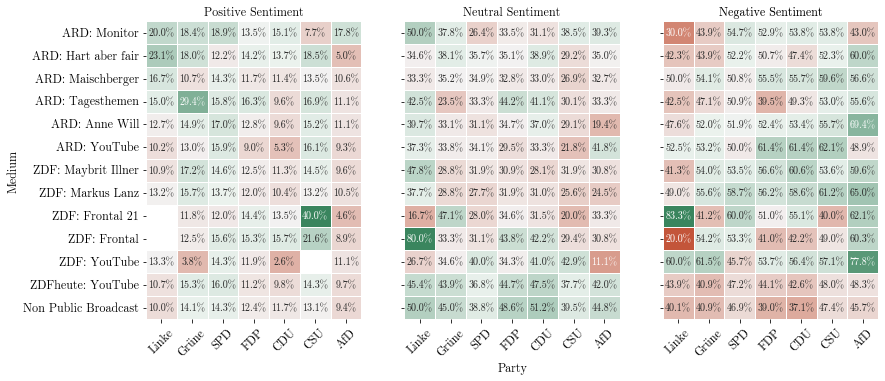

In [36]:
f, axs = plt.subplots(1,3,sharey=True)
f.subplots_adjust(left=0.16, bottom=.15, right=.98, top=.95)

sns.heatmap(pos, annot=True, linewidths=.5, ax=axs[0], fmt=".1%", center=np.nanmean(pos), cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed(), cbar=False)
sns.heatmap(neu, annot=True, linewidths=.5, ax=axs[1], fmt=".1%", center=np.nanmean(neu), cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed(), cbar=False)
sns.heatmap(neg, annot=True, linewidths=.5, ax=axs[2], fmt=".1%", center=np.nanmean(neg), cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed(), cbar=False)
axs[0].set_ylabel('Medium', size=12, font=fpath, color='black')
axs[0].set_title('Positive Sentiment', size=12, font=fpath, color='black')
axs[1].set_xlabel('Party', size=12, font=fpath, color='black')
axs[1].set_ylabel('')
axs[1].set_title('Neutral Sentiment', size=12, font=fpath, color='black')
axs[2].set_title('Negative Sentiment')
axs[2].set_ylabel('')
axs[0].set_xticklabels(['Linke', 'Grüne', 'SPD', 'FDP', 'CDU', 'CSU', 'AfD'], size=12, font=fpath, color='black', rotation=45)
axs[1].set_xticklabels(['Linke', 'Grüne', 'SPD', 'FDP', 'CDU', 'CSU', 'AfD'], size=12, font=fpath, color='black', rotation=45)
axs[2].set_xticklabels(['Linke', 'Grüne', 'SPD', 'FDP', 'CDU', 'CSU', 'AfD'], size=12, font=fpath, color='black', rotation=45)
axs[0].set_yticklabels(['ARD: Monitor', 'ARD: Hart aber fair', 'ARD: Maischberger', 'ARD: Tagesthemen', 'ARD: Anne Will', 'ARD: YouTube', 'ZDF: Maybrit Illner', 'ZDF: Markus Lanz', 'ZDF: Frontal 21', 'ZDF: Frontal', 'ZDF: YouTube', 'ZDFheute: YouTube', 'Non Public Broadcast'], size=12, font=fpath, color='black')
f.set_size_inches(width, height)
f.savefig('../results/englisch/sentiment_mediathek.pdf')


In [22]:
subset_ard = ['ARD_Monitor', 'ARD_Hart aber fair', 'ARD_Maischberger', 'ARD_Tagesthemen', 'ARD_Anne Will', 'ARD_youtube']
subset_zdf = ['ZDF_maybrit illner', 'ZDF_Markus Lanz', 'ZDF_Frontal 21', 'ZDF_frontal', 'ZDF_youtube', 'ZDFh_youtube']
subset_talk = ['ARD_Hart aber fair', 'ARD_Maischberger', 'ARD_Anne Will', 'ZDF_maybrit illner', 'ZDF_Markus Lanz']
subset_magazin = ['ARD_Monitor', 'ARD_Tagesthemen', 'ZDF_Frontal 21', 'ZDF_frontal']
subset_mediathek = ['ARD_Monitor', 'ARD_Hart aber fair', 'ARD_Maischberger', 'ARD_Tagesthemen', 'ARD_Anne Will', 'ZDF_maybrit illner', 'ZDF_Markus Lanz', 'ZDF_Frontal 21', 'ZDF_frontal']
subset_youtube = ['ARD_youtube', 'ZDF_youtube', 'ZDFh_youtube', 'rest']

In [23]:
def factor_sent_df(df):
    means = pd.DataFrame()

    ard_means = df.loc[subset_ard].mean().to_frame().T
    ard_means.index = ['ARD']
    means = pd.concat([means, ard_means])

    zdf_means = df.loc[subset_zdf].mean().to_frame().T
    zdf_means.index = ['ZDF']
    means = pd.concat([means, zdf_means])

    talk_means = df.loc[subset_talk].mean().to_frame().T
    talk_means.index = ['Talk']
    means = pd.concat([means, talk_means])

    magazin_means = df.loc[subset_magazin].mean().to_frame().T
    magazin_means.index = ['Magazin']
    means = pd.concat([means, magazin_means])

    mediathek_means = df.loc[subset_mediathek].mean().to_frame().T
    mediathek_means.index = ['Mediathek']
    means = pd.concat([means, mediathek_means])

    youtube_means = df.loc[subset_youtube].mean().to_frame().T
    youtube_means.index = ['YouTube']
    means = pd.concat([means, youtube_means])

    return means

In [24]:
pos_means = factor_sent_df(pos)
neu_means = factor_sent_df(neu)
neg_means = factor_sent_df(neg)

In [25]:
%matplotlib inline

/var/folders/k5/jm1h82sn2vd8d4f_0f1091r00000gn/T/ipykernel_18495/1032589225.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  f, ax = plt.subplots(figsize=(9, 8))
/Users/hs/miniforge3/lib/python3.9/site-packages/seaborn/matrix.py:312: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)
/Users/hs/miniforge3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from current font.
  fig.canvas.draw()


[Text(0.5, 48.375, 'party'),
 Text(57.875, 0.5, 'subset'),
 Text(0.5, 1.0, 'positive sentiment proportions by medium subset and party')]

/Users/hs/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


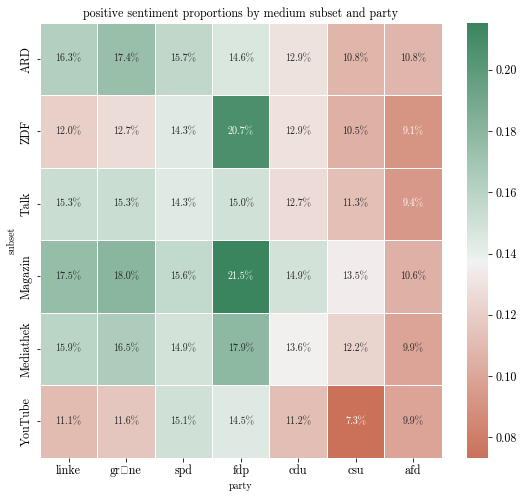

In [45]:
df_to_plot = pos_means[['linke', 'grüne', 'spd', 'fdp', 'cdu', 'csu', 'afd']]
f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(df_to_plot, annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(df_to_plot), cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed())
ax.set(xlabel='party', ylabel='subset', title='positive sentiment proportions by medium subset and party')

/var/folders/k5/jm1h82sn2vd8d4f_0f1091r00000gn/T/ipykernel_18495/1651188539.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  f, ax = plt.subplots(figsize=(9, 8))
/Users/hs/miniforge3/lib/python3.9/site-packages/seaborn/matrix.py:312: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)
/Users/hs/miniforge3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from current font.
  fig.canvas.draw()


[Text(0.5, 48.375, 'party'),
 Text(57.875, 0.5, 'subset'),
 Text(0.5, 1.0, 'neutral sentiment proportions by medium subset and party')]

/Users/hs/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


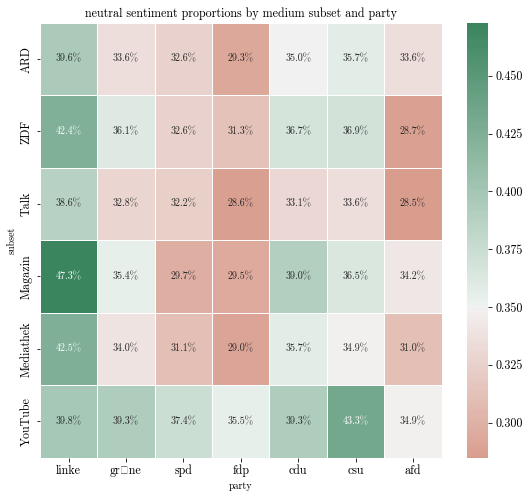

In [46]:
df_to_plot = neu_means[['linke', 'grüne', 'spd', 'fdp', 'cdu', 'csu', 'afd']]
f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(df_to_plot, annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(df_to_plot), cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed())
ax.set(xlabel='party', ylabel='subset', title='neutral sentiment proportions by medium subset and party')

/var/folders/k5/jm1h82sn2vd8d4f_0f1091r00000gn/T/ipykernel_18495/3257642002.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  f, ax = plt.subplots(figsize=(9, 8))
/Users/hs/miniforge3/lib/python3.9/site-packages/seaborn/matrix.py:312: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)
/Users/hs/miniforge3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from current font.
  fig.canvas.draw()


[Text(0.5, 48.375, 'party'),
 Text(57.875, 0.5, 'subset'),
 Text(0.5, 1.0, 'negative sentiment proportions by medium subset and party')]

/Users/hs/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


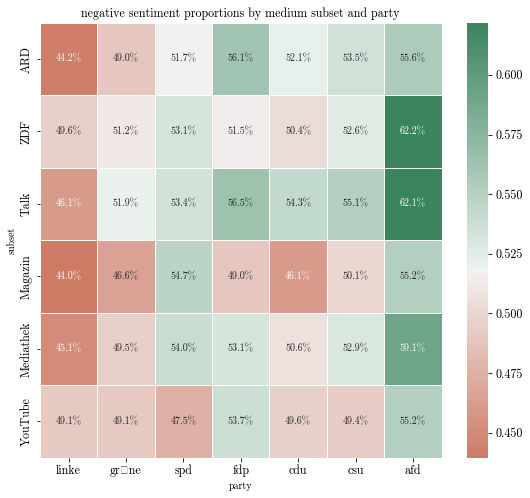

In [47]:
df_to_plot = neg_means[['linke', 'grüne', 'spd', 'fdp', 'cdu', 'csu', 'afd']]
f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(df_to_plot, annot=True, linewidths=.5, ax=ax, fmt=".1%", center=np.nanmean(df_to_plot), cmap=sns.diverging_palette(145, 20, as_cmap=True).reversed())
ax.set(xlabel='party', ylabel='subset', title='negative sentiment proportions by medium subset and party')

In [48]:
pos_means_melt = pos_means
pos_means_melt['subset'] = pos_means_melt.index
pos_means_melt = pos_means_melt.melt(id_vars=['subset'], value_vars=['linke', 'grüne', 'spd', 'fdp', 'cdu', 'csu', 'afd'])
pos_means_melt.columns=['subset', 'party', 'positive_sentiment_mean']

In [49]:
neu_means_melt = neu_means
neu_means_melt['subset'] = neu_means_melt.index
neu_means_melt = neu_means_melt.melt(id_vars=['subset'], value_vars=['linke', 'grüne', 'spd', 'fdp', 'cdu', 'csu', 'afd'])
neu_means_melt.columns=['subset', 'party', 'neutral_sentiment_mean']

In [50]:
neg_means_melt = neg_means
neg_means_melt['subset'] = neg_means_melt.index
neg_means_melt = neg_means_melt.melt(id_vars=['subset'], value_vars=['linke', 'grüne', 'spd', 'fdp', 'cdu', 'csu', 'afd'])
neg_means_melt.columns=['subset', 'party', 'negative_sentiment_mean']

/Users/hs/miniforge3/lib/python3.9/site-packages/seaborn/relational.py:703: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


<AxesSubplot:xlabel='party', ylabel='positive_sentiment_mean'>

/Users/hs/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


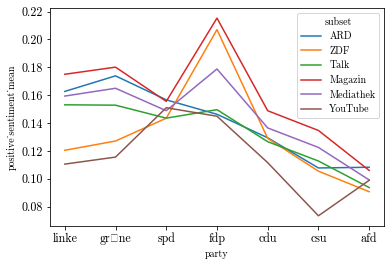

In [51]:
sns.lineplot(data=pos_means_melt, x='party', y='positive_sentiment_mean', hue='subset')

/Users/hs/miniforge3/lib/python3.9/site-packages/seaborn/relational.py:703: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


<AxesSubplot:xlabel='party', ylabel='neutral_sentiment_mean'>

/Users/hs/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


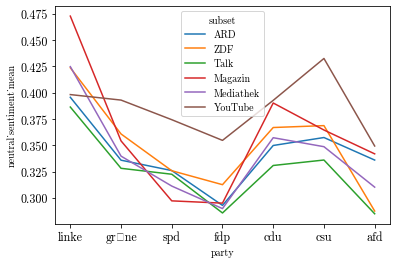

In [52]:
sns.lineplot(data=neu_means_melt, x='party', y='neutral_sentiment_mean', hue='subset')

/Users/hs/miniforge3/lib/python3.9/site-packages/seaborn/relational.py:703: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


<AxesSubplot:xlabel='party', ylabel='negative_sentiment_mean'>

/Users/hs/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


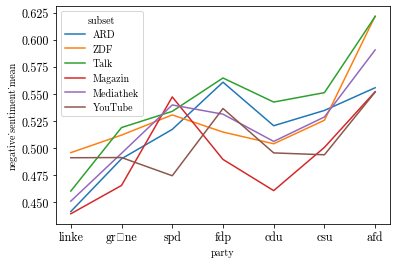

In [53]:
sns.lineplot(data=neg_means_melt, x='party', y='negative_sentiment_mean', hue='subset')